In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from plottable import Table, ColumnDefinition
from plottable.plots import bar 
import gseapy
import textwrap
import statsmodels.api as sm
from scipy.stats import pearsonr
from matplotlib_venn import venn2, venn3

In [20]:
sel_tissues = [46, 47, 105, 277, 276, 278, 239, 323]
sel_tissues_names = ['iPSC', 'H1-hESC', 'Cardiac myocyte from RUES2', 'Liver', 'Liver', 'Liver', 'Neural progenitor from H9', 'Testis']

with open('/project/deeprna/data/experiments_final.txt', 'r') as f:
    experiments = f.read().splitlines()

experiment_mask = np.load('/project/deeprna_data/pretraining_data_final2/experiment_mask.npy')

selected_assays = ['dnase', 'h3k4me1', 'h3k4me2', 'h3k4me3', 'h3k9ac', 'h3k9me3', 'h3k27ac', 'h3k27me3', 'h3k36me3', 'h3k79me2', 'ctcf']

trans_exp = np.load('/project/deeprna_data/pretraining_data_final2/tf_expression.npy')
trans_exp = trans_exp[sel_tissues]

with open('/project/deeprna/data/tf_genes/trans_regulators_final_hgnc.txt', 'r') as f:
    tf_genes = f.read().splitlines()

trans_cont = torch.load('/project/deeprna/data/revision/trans_contrib_dlshap2_delta.pt').abs()

/scratch/local/ipykernel_73794/2741536031.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trans_cont = torch.load('/project/deeprna/data/revision/trans_contrib_dlshap2_

In [21]:
trans_cont = torch.div(trans_cont, torch.from_numpy(trans_exp.T[:, :, np.newaxis] + 0.1))
trans_cont.shape

torch.Size([2891, 8, 200])

In [23]:
trans_exp.shape

(8, 2891)

## Fig. 5b

In [31]:
k = 100
all_results = {}
for i,tissue in enumerate(sel_tissues):
    all_results[tissue] = {}
    print(f'Tissue {tissue}')
    cont_scores = trans_cont[:, i, :].sum(axis=1).numpy()

    # Filter low expressed genes
    passed = trans_exp[i, :] > 0.2
    cont_scores = cont_scores[passed]
    tf_genes_filtered = np.array(tf_genes)[passed]
    topk_idx = np.argsort(-cont_scores)[:k]
    topk_genes = tf_genes_filtered[topk_idx].tolist()
    enr = gseapy.enrichr(gene_list=topk_genes,
                            gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human', 'CellMarker_2024', 'ClinVar_2025'],
                            organism='Human',
                            outdir=None)
    if not enr.results.empty:
        res = enr.results.sort_values('Adjusted P-value')
        res = res.loc[res['Adjusted P-value'] < 0.05]
        #print(res[['Term', 'Adjusted P-value', 'Overlap', 'Genes']].head(10))
        all_results[tissue] = res

Tissue 46
Tissue 47
Tissue 105
Tissue 277
Tissue 276
Tissue 278
Tissue 239
Tissue 323


In [39]:
# gene enrichment with top 100 expressed genes
k = 100
all_results_exp = {}
for i,tissue in enumerate(sel_tissues):
    all_results_exp[tissue] = {}
    print(f'Tissue {tissue}')
    exp_scores = trans_exp[i, :]
    topk_idx = np.argsort(-exp_scores)[:k]
    topk_genes = [tf_genes[i] for i in topk_idx]
    enr = gseapy.enrichr(gene_list=topk_genes,
                            gene_sets=['MSigDB_Hallmark_2020','KEGG_2021_Human', 'CellMarker_2024', 'ClinVar_2025'],
                            organism='Human',
                            outdir=None)
    if not enr.results.empty:
        res = enr.results.sort_values('Adjusted P-value')
        res = res.loc[res['Adjusted P-value'] < 0.05]
        #print(res[['Term', 'Adjusted P-value', 'Overlap', 'Genes']].head(10))
        all_results_exp[tissue] = res

Tissue 46
Tissue 47
Tissue 105
Tissue 277
Tissue 276
Tissue 278
Tissue 239
Tissue 323


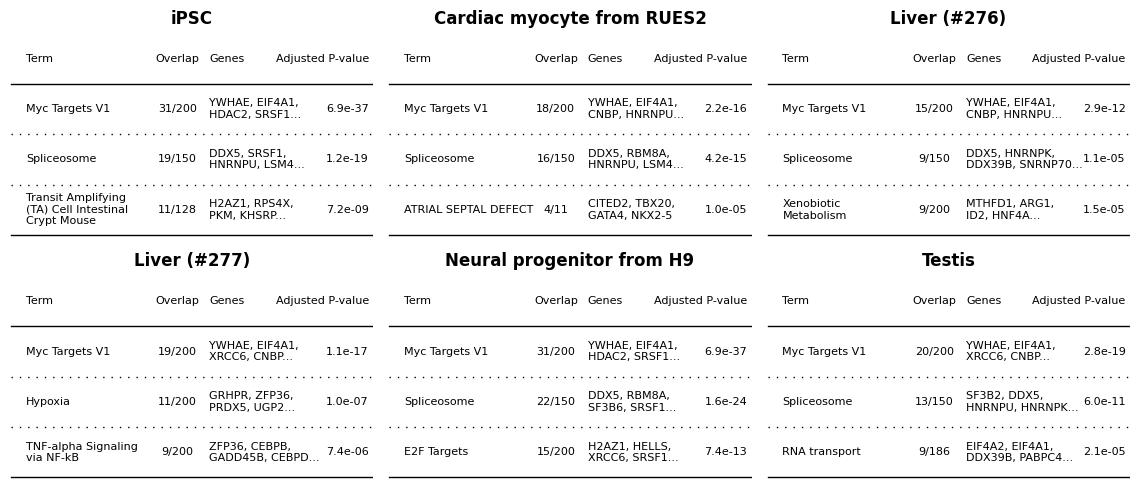

In [40]:
# Plot enrichment results for 5 tissues: 46, 105, 276, 239, 323
# Get top 3 terms per tissue, ranked by Adjusted P-value
# Two rows, first row 3, second row 2 tables
# Table columns: Term, Overlap, Genes, Adjusted P-value
# Also show -log10(Adjusted P-value) as small horizontal bar plot next to table)

fig, axes = plt.subplots(2, 3, figsize=(11.5, 5))

tissues_to_plot = [46, 105, 276, 277, 239, 323]
tissue_names = ['iPSC', 'Cardiac myocyte from RUES2', 'Liver (#276)', 'Liver (#277)', 'Neural progenitor from H9', 'Testis']

for i, tissue in enumerate(tissues_to_plot):
    ax = axes[i//3, i%3]
    res = all_results_exp[tissue]
    if res.empty:
        ax.axis('off')
        continue

    top_terms = res.sort_values('Adjusted P-value').head(3)
    table_data = top_terms[['Term', 'Overlap', 'Genes', 'Adjusted P-value']].copy()

    # Genes: if more than 4, truncate with "..."
    def truncate_genes(genes_str):
        genes = genes_str.split(';')
        if 2 < len(genes) <= 4:
            # Two rows of 2 genes each
            return ',\n'.join([', '.join(genes[:2]), ', '.join(genes[2:4])])
        if len(genes) > 4:
            # Two rows of 2 genes each, put ... at the end
            return ',\n'.join([', '.join(genes[:2]), ', '.join(genes[2:4]) + '...'])
        else:
            return ', '.join(genes)
    
    def wrap_text(text, width=20):
        return '\n'.join(textwrap.wrap(text, width=width))

    table_data['Term'] = table_data['Term'].apply(wrap_text)
    table_data['Genes'] = table_data['Genes'].apply(truncate_genes)
    table_data.set_index('Term', inplace=True)
    col_defs = [
        ColumnDefinition(name="Term", width=4.2, textprops={"ha": "left"}),
        ColumnDefinition(name="Overlap", width=1, textprops={"ha": "center"}),
        ColumnDefinition(name="Genes", width=4, textprops={"ha": "left"}),
        ColumnDefinition(name="Adjusted P-value", width=1, formatter="{:.1e}"),
    ]
    plt.rcParams["savefig.bbox"] = "tight"
    # 3. Plot the Table
    tab = Table(
        table_data,
        ax=ax,
        column_definitions=col_defs,
        row_dividers=True,
        footer_divider=True,
        textprops={"fontsize": 8},
        row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    )
    
    ax.set_title(f'{tissue_names[i]}', fontweight='bold')

plt.tight_layout()
#plt.savefig('/project/deeprna/corgi-reproduction/figures_2/fig5b.pdf', dpi=300)

## Fig. 5c

/scratch/local/ipykernel_73794/4208978758.py:33: RuntimeWarning: invalid value encountered in sqrt
  tissue_exp = np.where(tissue_exp > 5, 5 + np.sqrt(tissue_exp - 5), tissue_exp)
/scratch/local/ipykernel_73794/4208978758.py:34: RuntimeWarning: invalid value encountered in sqrt
  tissue_exp = np.where(tissue_exp < -5, -5 - np.sqrt(-5 - tissue_exp), tissue_exp)


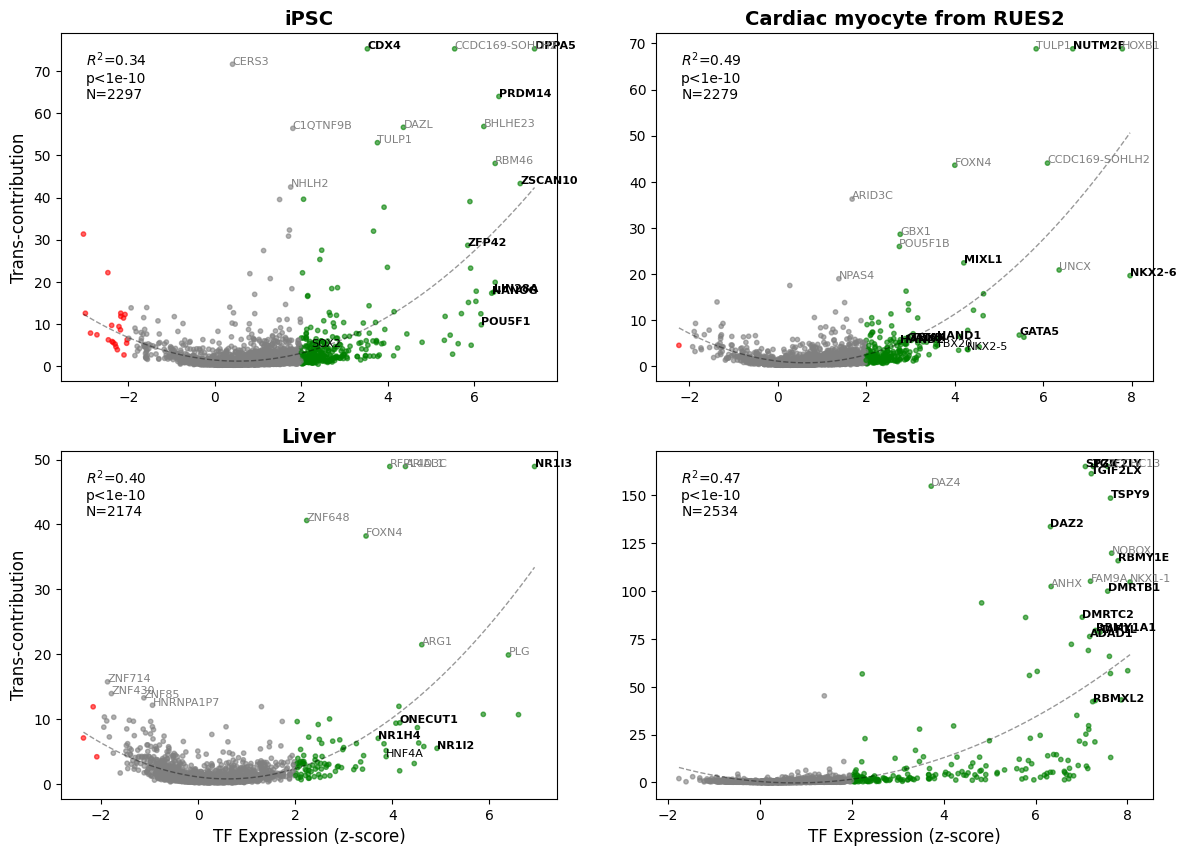

In [30]:
# 2 x 2 plot, with tissues 46, 105, 276, 323
trans_exp_all = np.load('/project/deeprna_data/pretraining_data_final2/tf_expression.npy')
low_exp_threshold = 0.5
tissues_to_plot = [46, 105, 276, 323]
tissue_names = ['iPSC', 'Cardiac myocyte from RUES2', 'Liver', 'Testis']

# Marker genes: Label these genes in red. If they are in top 100 contributing TFs, make them bold red.
marker_genes_dict = {
    46: ['POU5F1', 'SOX2', 'NANOG', 'ZFP42', 'ZSCAN10', 'PRDM14', 'DPPA5', 'CDX4', 'LIN28A'],   # iPSC
    105: ['NKX2-5', 'MIXL1', 'NKX2-6', 'NUTM2F', 'GATA5', 'GATA4', 'TBX5', 'TBX20', 'HAND1', 'HAND2'],  # Cardiac myocyte
    276: ['HNF4A', 'NR1I3', 'ONECUT1', 'NR1H4', 'NR1I2'],      # Liver
    323: ['ADAD1', 'DAZ2', 'DMRTB1', 'DMRTC2', 'RBMY1A1', 'RBMY1E', 'SPZ1', 'TGIF2LX', 'TGIF2LY', 'TSPY9', 'RBMXL2', 'TAF1L'],    # Testis
}

# Other genes in top 99.5 percentile of trans contribution scores: grey
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
for i, tissue in enumerate(tissues_to_plot):
    ax = axes[i//2, i%2]
    tissue_index = sel_tissues.index(tissue)
    # Drop very low expressed genes in this tissue
    trans_exp_tissue = trans_exp_all[tissue, :]
    passing_genes = trans_exp_tissue >= low_exp_threshold
    trans_exp_all_filtered = trans_exp_all[:, passing_genes]
    trans_exp_all_f_z = (trans_exp_all_filtered - trans_exp_all_filtered.mean(axis=0, keepdims=True)) / (trans_exp_all_filtered.std(axis=0, keepdims=True) + 1e-4)
    tissue_exp = trans_exp_all_f_z[tissue, :]
    genes = np.array(tf_genes)[passing_genes]

    # Data
    cont = trans_cont.numpy()
    tissue_cont = cont[passing_genes, tissue_index, :].mean(axis=1)    # Average across genomic regions

    # Clipping outliers
    tissue_exp = np.where(tissue_exp > 5, 5 + np.sqrt(tissue_exp - 5), tissue_exp)
    tissue_exp = np.where(tissue_exp < -5, -5 - np.sqrt(-5 - tissue_exp), tissue_exp)
    tissue_cont = np.clip(tissue_cont, np.percentile(tissue_cont, 0.1), np.percentile(tissue_cont, 99.9))

    # Scatter plot
    colors = []
    for z in tissue_exp:
        if z > 2:
            colors.append('green')
        elif z < -2:
            colors.append('red')
        else:
            colors.append('gray')

    # Main plot
    ax.scatter(tissue_exp, tissue_cont, c=colors, alpha=0.6, s=10)
    ax.set_xlabel('TF Expression (z-score)', fontsize=12)
    ax.set_ylabel('Trans-contribution', fontsize=12)
    ax.set_title(f'{tissue_names[i]}', fontsize=14, fontweight='bold')

    # Annotate marker genes
    marker_genes = marker_genes_dict[tissue]
    for gene in marker_genes:
        if gene in genes:
            gene_idx = np.where(genes == gene)[0][0]
            x = tissue_exp[gene_idx]
            y = tissue_cont[gene_idx]
            if gene in genes[np.argsort(-tissue_cont)[:100]]:
                ax.text(x, y, gene, color='black', fontsize=8, fontweight='bold')
            else:
                ax.text(x, y, gene, color='black', fontsize=8, fontweight='normal')
    
    # Annotate top 0.5 percentile contributing TFs
    for idx in range(len(genes)):
        if tissue_cont[idx] > np.percentile(tissue_cont, 99.5):
            gene = genes[idx]
            if gene not in marker_genes:
                x = tissue_exp[idx]
                y = tissue_cont[idx]
                ax.text(x, y, gene, color='gray', fontsize=8)

    # Parabola fit and p-value
    coeffs = np.polyfit(tissue_exp, tissue_cont, 2)
    poly = np.poly1d(coeffs)
    x_vals = np.linspace(min(tissue_exp), max(tissue_exp), 100)
    y_vals = poly(x_vals)
    ax.plot(x_vals, y_vals, color='black', alpha=0.4, linestyle='--', linewidth=1)

    # P-val with statsmodels
    X_stats = np.column_stack([tissue_exp**2, tissue_exp])
    X_stats = sm.add_constant(X_stats)
    results = sm.OLS(tissue_cont, X_stats).fit()
    p_val = results.f_pvalue

    # R2
    y_mean = np.mean(tissue_cont)
    ss_tot = np.sum((tissue_cont - y_mean) ** 2)
    ss_res = np.sum((tissue_cont - poly(tissue_exp)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)

    # Write R2, p-val, N on all subplots
    if p_val < 1e-10:
        p_text = f'p<1e-10'
    else:
        p_text = f'p={p_val:.2e}'
    ax.text(0.05, 0.95, f'$R^2$={r_squared:.2f}\n{p_text}\nN={len(genes)}', transform=ax.transAxes,
            verticalalignment='top', fontsize=10)

    # Remove y labels for right plots, x labels for top plots
    if i % 2 == 1:
        ax.set_ylabel('')
    if i // 2 == 0:
        ax.set_xlabel('')
plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.2, wspace=0.2)
# plt.savefig('/project/deeprna/corgi-reproduction/figures_2/fig5c.pdf', dpi=300)

In [9]:
# List of top 0.5 percentile for chosen 4 tissues
for tissue in tissues_to_plot:
    tissue_index = sel_tissues.index(tissue)
    # Drop very low expressed genes in this tissue
    trans_exp_tissue = trans_exp_all[tissue, :]
    passing_genes = trans_exp_tissue >= low_exp_threshold
    trans_exp_all_filtered = trans_exp_all[:, passing_genes]
    trans_exp_all_f_z = (trans_exp_all_filtered - trans_exp_all_filtered.mean(axis=0, keepdims=True)) / (trans_exp_all_filtered.std(axis=0, keepdims=True) + 1e-4)
    tissue_exp = trans_exp_all_f_z[tissue, :]
    genes = np.array(tf_genes)[passing_genes]

    # Data
    cont = trans_cont.numpy()
    tissue_cont = cont[passing_genes, tissue_index, :].mean(axis=1)    # Average across genomic regions

    # Clipping outliers
    tissue_exp = np.where(tissue_exp > 5, 5 + np.sqrt(tissue_exp - 5), tissue_exp)
    tissue_exp = np.where(tissue_exp < -5, -5 - np.sqrt(-5 - tissue_exp), tissue_exp)
    tissue_cont = np.clip(tissue_cont, np.percentile(tissue_cont, 0.1), np.percentile(tissue_cont, 99.9))

    # Print top 0.5 percent
    print(f'Tissue {tissue} top 0.5 percentile contributing TFs:')
    for idx in range(len(genes)):
        if tissue_cont[idx] > np.percentile(tissue_cont, 99):
            gene = genes[idx]
            print(gene)
    

/scratch/local/ipykernel_130574/3037641545.py:17: RuntimeWarning: invalid value encountered in sqrt
  tissue_exp = np.where(tissue_exp > 5, 5 + np.sqrt(tissue_exp - 5), tissue_exp)
/scratch/local/ipykernel_130574/3037641545.py:18: RuntimeWarning: invalid value encountered in sqrt
  tissue_exp = np.where(tissue_exp < -5, -5 - np.sqrt(-5 - tissue_exp), tissue_exp)


Tissue 46 top 0.5 percentile contributing TFs:
BHLHE23
C1QTNF9B
CCDC169-SOHLH2
CDX4
CERS3
DAZL
DPPA5
FOXH1
LIN28A
NANOG
NANOGP8
NHLH2
NKX1-2
POU5F1
PRDM14
RBM46
SOX21
SOX3
TCF24
TULP1
ZFP42
ZNF732
ZSCAN10
Tissue 105 top 0.5 percentile contributing TFs:
ADGRG7
ALX1
ANXA1
ARID3C
CCDC169-SOHLH2
FOXN4
GATA4
GATA5
GBX1
HAND2
HOXB1
IRX1
IRX2
IRX4
LIN28A
MIXL1
NKX2-6
NUTM2F
POU5F1B
TULP1
UNCX
ZNF699
ZSCAN1
Tissue 276 top 0.5 percentile contributing TFs:
A1CF
ADGRG7
ARG1
ARID3C
CUX2
ESR1
FOXN4
GNMT
LBX2
LIPC
MYCL
NR1H4
NR1I2
NR1I3
ONECUT1
PLG
RFPL4AL1
SLC17A2
SLC22A9
SSTR1
ZNF648
ZNF83
Tissue 323 top 0.5 percentile contributing TFs:
ADAD1
ANHX
CDY1B
DAZ2
DAZ4
DMRTB1
DMRTC2
FAM9A
FOXR1
HMGB4
MYCLP1
NKX1-1
NOBOX
PDILT
RBMXL2
RBMY1A1
RBMY1E
RNF113B
SPDYE4
SPZ1
TAF1L
TGIF2LX
TGIF2LY
TRIM43
TSPY9
ZCCHC13


## Fig. 5d

In [35]:
pvals = []
r_coefs = []
median_exps = []
slopes = []
for gene_idx, gene in enumerate(tf_genes):
    cont = trans_cont.numpy()
    gene_cont = cont[gene_idx, :, :].mean(axis=1)    # Average across genomic regions
    gene_exp = trans_exp_all[sel_tissues, gene_idx]

    # Skip if median gene exp is too low
    if np.median(gene_exp) < 0.5:
        pvals.append(np.nan)
        r_coefs.append(np.nan)
        slopes.append(np.nan)
        median_exps.append(np.median(gene_exp))
        continue
    # Calculate linear correlation coef. and p-value
    corr_coef, p_value = pearsonr(gene_exp, gene_cont)
    pvals.append(p_value)
    r_coefs.append(corr_coef)

    # Calculate slop of linear regression line
    X = sm.add_constant(gene_exp)
    model = sm.OLS(gene_cont, X).fit()
    slope = model.params[1]
    slopes.append(slope)

    # Median expression
    median_exp = np.median(gene_exp)
    median_exps.append(median_exp)

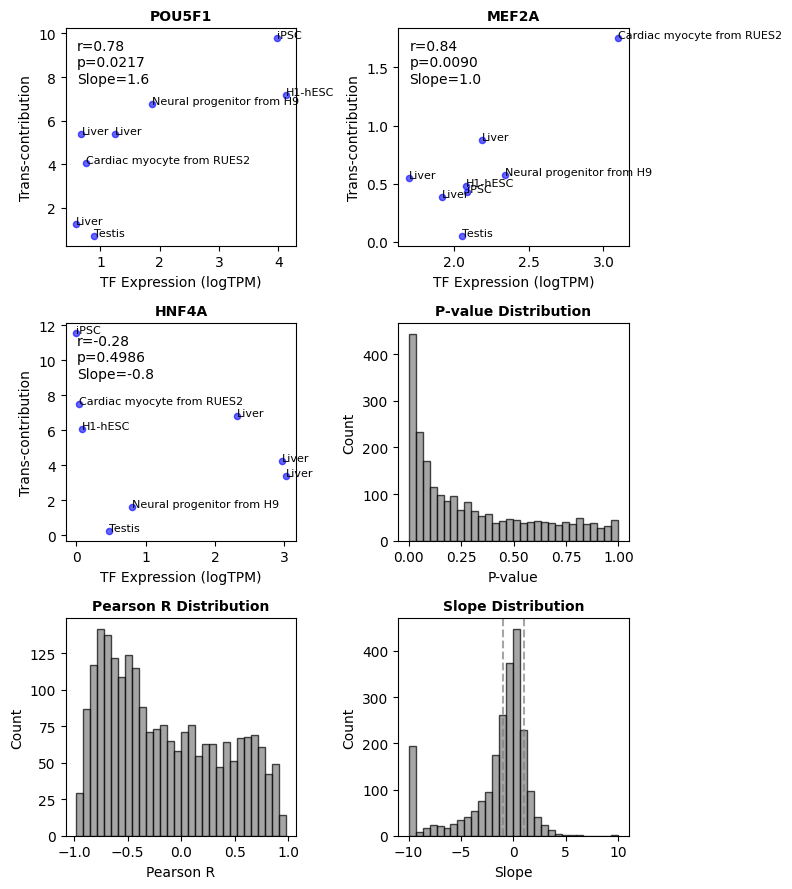

In [36]:
# Fig 5d: 2 cols, 3 rows. 
# First 3: chosen 3 TFs scatterplot. 4: p-value histogram. 5: R² histogram. 6: slope histogram.
fig, axes = plt.subplots(3, 2, figsize=(8,9))
chosen_tfs = ['POU5F1', 'MEF2A', 'HNF4A']

slopes = np.array(slopes)
slopes = np.clip(slopes, -10, 10)

for i, tf in enumerate(chosen_tfs):
    if i == 0:
        ax = axes[0,0]
    elif i == 1:
        ax = axes[0,1]
    else:
        ax = axes[1,0]
    gene_idx = tf_genes.index(tf)
    cont = trans_cont.numpy()
    gene_cont = cont[gene_idx, :, :].mean(axis=1)
    gene_exp = trans_exp_all[sel_tissues, gene_idx]
    # Calculate linear correlation coef. and p-value
    corr_coef, p_value = pearsonr(gene_exp, gene_cont)
    # Calculate slope of linear regression line
    X = sm.add_constant(gene_exp)
    model = sm.OLS(gene_cont, X).fit()
    slope = model.params[1]

    ax.scatter(gene_exp, gene_cont, c='blue', alpha=0.6, s=20)
    ax.set_xlabel('TF Expression (logTPM)')
    ax.set_ylabel('Trans-contribution')
    ax.set_title(f'{tf}', fontsize=10, fontweight='bold')
    ax.text(0.05, 0.95, f'r={corr_coef:.2f}\np={p_value:.4f}\nSlope={slope:.1f}', transform=ax.transAxes, fontsize=10, verticalalignment='top')
    # Label all 8 tissues in the plot
    for idx in range(len(sel_tissues)):
        ax.text(gene_exp[idx], gene_cont[idx], sel_tissues_names[idx], fontsize=8)

# Histograms: axes[1,1], axes[2,0], axes[2,1]
for ax, data, title, xlabel in zip(
    [axes[1,1], axes[2,0], axes[2,1]],
    [pvals, r_coefs, slopes],
    ['P-value Distribution', 'Pearson R Distribution', 'Slope Distribution'],
    ['P-value', 'Pearson R', 'Slope']
):
    ax.hist(data, bins=30, color='gray', edgecolor='black', alpha=0.7)
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Count')

    # For the slopes histogram, add vertical lines at -1 and 1
    if xlabel == 'Slope':
        ax.axvline(x=-1, color='grey', linestyle='--', alpha=0.7)
        ax.axvline(x=1, color='grey', linestyle='--', alpha=0.7)

plt.tight_layout()
# plt.savefig('/project/deeprna/corgi-reproduction/figures_2/fig5d.pdf', dpi=300)

## Fig. 5e

In [55]:
score_file = '/project/deeprna/data/revision/cis_contributions_delta.pt'
scores = torch.load(score_file)

cis_cont = np.load('/project/deeprna/data/revision/cis_tfbs_matrix_z.npy')
cis_cont_tfnames = np.load('/project/deeprna/data/revision/cis_tfbs_matrix_z_tfnames.npy')
cis_cont_idx = [idx for idx, tf in enumerate(cis_cont_tfnames) if tf in tf_genes]

/scratch/local/ipykernel_130574/423638171.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  scores = torch.load(score_file)


In [69]:
for i, tissue in enumerate(sel_tissues):

    gene_exp_z = (trans_exp_all[:, cis_cont_idx] - trans_exp_all[:, cis_cont_idx].mean(axis=0, keepdims=True)) / (trans_exp_all[:, cis_cont_idx].std(axis=0, keepdims=True) + 1e-4)
    gene_exp_tissue = gene_exp_z[i, :]
    high_genes = np.abs(gene_exp_tissue) > 1
    cis_cont_tissue = cis_cont[i, :][high_genes]
    trans_cont_tissue = trans_cont[cis_cont_idx, i, :].mean(axis=1).numpy()[high_genes]

    print(tissue, pearsonr(cis_cont_tissue, trans_cont_tissue), len(cis_cont_tissue))

46 PearsonRResult(statistic=-0.0017420486958308577, pvalue=0.963940340655864) 676
47 PearsonRResult(statistic=0.004526619933043048, pvalue=0.9185375112597678) 513
105 PearsonRResult(statistic=-0.2559769789933359, pvalue=0.013264925008641577) 93
277 PearsonRResult(statistic=-0.008604427016614662, pvalue=0.919051002999126) 142
276 PearsonRResult(statistic=-0.03512713270130187, pvalue=0.6748834855612444) 145
278 PearsonRResult(statistic=0.024442806618584244, pvalue=0.7751716204375177) 139
239 PearsonRResult(statistic=0.0983612884203038, pvalue=0.25106808911688516) 138
323 PearsonRResult(statistic=0.1350568216150415, pvalue=0.11425068554770619) 138


In [ ]:
trans_exp[sel_tissues, tf_idx]

(8, 1318)

In [83]:
trans_exp.shape

(8, 2891)

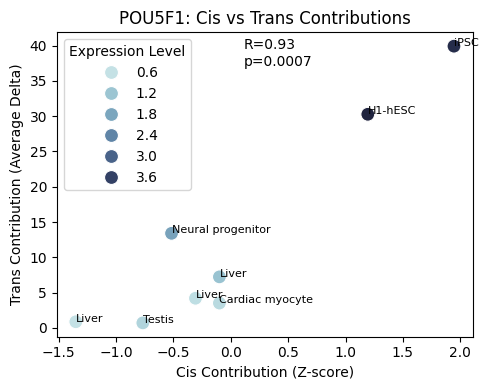

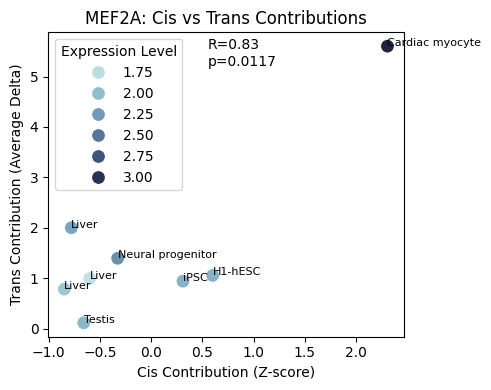

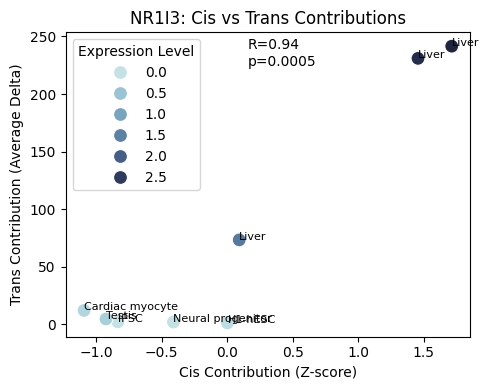

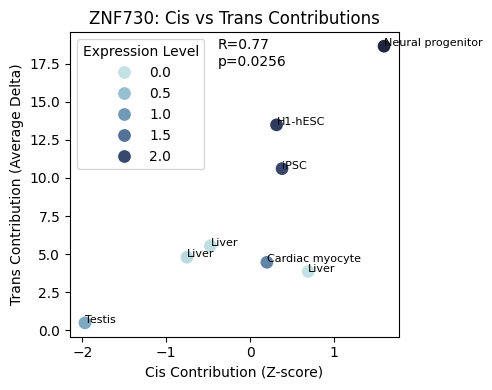

In [91]:
# Chosen TFs: cis vs trans contributions scatterplots, with expression as hue
tfs_to_plot = ['POU5F1', 'MEF2A', 'NR1I3', 'ZNF730']
sel_tissues_names_short = ['iPSC', 'H1-hESC', 'Cardiac myocyte', 'Liver', 'Liver', 'Liver', 'Neural progenitor', 'Testis']

for tf in tfs_to_plot:
    tf_idx = tf_genes.index(tf)
    cis_values = cis_cont[:, list(cis_cont_tfnames).index(tf)]
    trans_values = trans_cont.numpy()[:, :, :].mean(axis=2)[tf_idx, :]
    exp_values = trans_exp[:, tf_idx]

    # Cor
    correlation, p_value = pearsonr(cis_values, trans_values)

    # Plot. Hue should have a continuous colorbar
    plt.figure(figsize=(5,4))
    cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
    sns.scatterplot(x=cis_values, y=trans_values, hue=exp_values, palette=cmap, s=100)
    #plt.colorbar(label='Expression Level (logTPM)')
    plt.text(0.45, 0.98, f'R={correlation:.2f}\np={p_value:.4f}', transform=plt.gca().transAxes, verticalalignment='top')
    plt.title(f'{tf}: Cis vs Trans Contributions')
    plt.xlabel('Cis Contribution (Z-score)')
    plt.ylabel('Trans Contribution (Average Delta)')
    plt.legend(title='Expression Level', loc='best')

    # Label tissue names
    for j, tissue_idx in enumerate(sel_tissues):
        plt.text(cis_values[j], trans_values[j], sel_tissues_names_short[j], fontsize=8)

    plt.tight_layout()
    plt.show()